In [10]:
import os
import librosa
import math
import json
DATASET_PATH="genres_original"
JSON_PATH="data.json"
SAMPLE_RATE=22050
DURATION=30
SAMPLES_PER_TRACK=SAMPLE_RATE*DURATION

def save_mfcc(dataset_path,JSON_PATH, n_mfcc=13, n_fft=2048, hop_length=512,num_segments=5):
    data={
        "mapping":[],"mfcc":[],"labels":[]
    }
    num_samples_per_segment=int(SAMPLES_PER_TRACK/num_segments)
    expected_num_mfcc_vectors_per_segment=math.ceil(num_samples_per_segment/hop_length)
    for i, (dirpath ,dirnames ,filenames) in enumerate (os. walk(dataset_path)):
        
        if dirpath is not dataset_path:
            dirpath_components = os.path.split(dirpath)
            semantic_label=dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print("\processing {}".format(semantic_label))

            for f in filenames:
                file_path=os.path.join(dirpath,f)
                signal, sr=librosa.load(file_path,sr=SAMPLE_RATE)
                for s in range(num_segments):
                    start_sample=num_samples_per_segment*s
                    finish_sample=start_sample+num_samples_per_segment
                    mfcc=librosa.feature.mfcc(y=signal[start_sample:finish_sample],sr=sr,n_fft=n_fft, n_mfcc=n_mfcc,hop_length=hop_length)
                    mfcc=mfcc.T
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{},segment:{}".format(file_path,s))
    with open(JSON_PATH, "w") as fp:
        json.dump(data, fp, indent=4)

if __name__ == "__main__":
    save_mfcc(DATASET_PATH,JSON_PATH,num_segments=10)
    

\processing blues
genres_original\blues\blues.00000.wav,segment:0
genres_original\blues\blues.00000.wav,segment:1
genres_original\blues\blues.00000.wav,segment:2
genres_original\blues\blues.00000.wav,segment:3
genres_original\blues\blues.00000.wav,segment:4
genres_original\blues\blues.00000.wav,segment:5
genres_original\blues\blues.00000.wav,segment:6
genres_original\blues\blues.00000.wav,segment:7
genres_original\blues\blues.00000.wav,segment:8
genres_original\blues\blues.00000.wav,segment:9
genres_original\blues\blues.00001.wav,segment:0
genres_original\blues\blues.00001.wav,segment:1
genres_original\blues\blues.00001.wav,segment:2
genres_original\blues\blues.00001.wav,segment:3
genres_original\blues\blues.00001.wav,segment:4
genres_original\blues\blues.00001.wav,segment:5
genres_original\blues\blues.00001.wav,segment:6
genres_original\blues\blues.00001.wav,segment:7
genres_original\blues\blues.00001.wav,segment:8
genres_original\blues\blues.00001.wav,segment:9
genres_original\blues\

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1690)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1690)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               865792    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 64)               

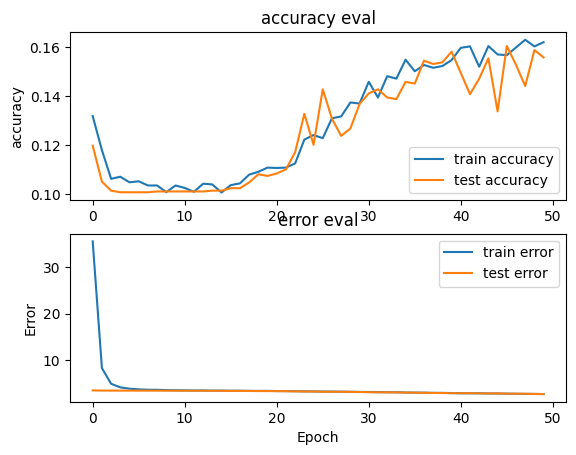

In [8]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
DATASET_PATH="data.json"
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
  #conv list to np arrays
    inputs=np.array(data["mfcc"])
    targets=np.array(data["labels"])
    return inputs,targets
def plot_history(history):
    fig,axis=plt.subplots(2)
    #accuracy
    axis[0].plot(history.history["accuracy"], label="train accuracy")
    axis[0].plot(history.history["val_accuracy"], label="test accuracy")
    axis[0].set_ylabel("accuracy")
    axis[0].legend(loc="lower right")
    axis[0].set_title("accuracy eval")
    axis[1].plot(history.history["loss"], label="train error")
    axis[1].plot(history.history["val_loss"], label="test error")
    axis[1].set_ylabel("Error")
    axis[1].set_xlabel("Epoch")
    axis[1].legend(loc="upper right")
    axis[1].set_title("error eval")
    plt.show()
if __name__=="__main__":
    inputs,targets=load_data(DATASET_PATH)
    iptrain,iptest,tartrain,tartest=train_test_split(inputs,targets,test_size=0.3)
    model=keras.Sequential([
      keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2])),
      keras.layers.Dropout(0.3),
        #1st layer
      keras.layers.Dense(512, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.Dropout(0.3),
        #2nd layer
      keras.layers.Dense(256, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.Dropout(0.3),
        #3rd layer
      keras.layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.Dropout(0.3),  
        #output layer
      keras.layers.Dense(10, activation="softmax")  
    ])
    #compile
    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    model.summary()
    #train network
    history = model.fit(iptrain,tartrain,validation_data=(iptest,tartest),epochs=50,batch_size=32)
    plot_history(history)
    
    